In [1]:
from datetime import datetime, timedelta
import requests
import json
import os
import env
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input
from keras.models import Model
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

def get_previous_business_day(date):
    if date.weekday() == 0:  
        return date - timedelta(days=3)
    elif date.weekday() == 6:  
        return date - timedelta(days=2)
    else:
        return date - timedelta(days=1)

def get_years_ago_from_date(date, num_years):
    years_ago = date.replace(year=date.year - num_years)
    return get_previous_business_day(years_ago)

current_time = datetime.now()
end_date = get_previous_business_day(current_time)
start_date = get_years_ago_from_date(end_date, num_years=25)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Start Date: {start_date_str}")
print(f"End Date: {end_date_str}")

Start Date: 1999-05-21
End Date: 2024-05-22


In [2]:
symbol = "AAPL"

url = f"https://data.alpaca.markets/v2/stocks/bars?symbols={symbol}&timeframe=1Day&start={start_date_str}&end={end_date_str}&limit=10000&adjustment=raw&feed=sip&sort=asc"

headers = {
    "accept": "application/json",
    "APCA-API-KEY-ID": os.getenv("api-id"),  # Use environment variable
    "APCA-API-SECRET-KEY": os.getenv("api-secret"),  # Use environment variable
}

response = requests.get(url, headers=headers)

data = response.json()

symbol = list(data['bars'].keys())[0]

df = pd.DataFrame(data['bars'][symbol]) 

# Rename columns 
df.columns = ['Closing Price', 'High', 'Low', 'Number of Trades', 'Open', 'Date', 'Volume', 'VWAP']

# Ensure 'Closing Price' is of type float
df['Closing Price'] = df['Closing Price'].astype(float)

# Fill missing values in 'Closing Price' with forward fill method
df['Closing Price'] = df['Closing Price'].ffill()

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Remove timezone and ensure YEAR-MM-DD format
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# Set 'Date' as the index
stockprices = df.set_index('Date')

#Preview DataSet
print(stockprices.head())

            Closing Price     High     Low  Number of Trades    Open  \
Date                                                                   
2016-01-04         105.35  105.368  102.00            351452  102.61   
2016-01-05         102.71  105.850  102.41            321365  105.75   
2016-01-06         100.70  102.370   99.87            409164  100.56   
2016-01-07          96.45  100.130   96.43            462836   98.68   
2016-01-08          96.96   99.110   96.76            419555   98.55   

              Volume        VWAP  
Date                              
2016-01-04  71935339  104.091749  
2016-01-05  58690536  103.400868  
2016-01-06  71079827  100.843959  
2016-01-07  85996453   98.011371  
2016-01-08  75066292   97.897369  


In [3]:
y = df['Closing Price']
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model

# Define the input shape
input_layer = Input(shape=(n_lookback, 1))

# Create the LSTM layers
lstm1 = LSTM(units=50, return_sequences=True)(input_layer)
lstm2 = LSTM(units=50)(lstm1)

# Create the output layer
output_layer = Dense(n_forecast)(lstm2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0293
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0063
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0058
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0053
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0048
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0045
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0041
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0037
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0035
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0033
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0032
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0030
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0029
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0030
Epoch 15/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - lo

In [4]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Closing Price', 'Date']]

df_past['Date'] = pd.to_datetime(df_past['Date'])

df_past.set_index('Date', inplace=True)
df_past['Date'] = df_past.index

print(df_past.index.name == 'Date')

print(df_past.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
True
            Closing Price       Date
Date                                
2016-01-04         105.35 2016-01-04
2016-01-05         102.71 2016-01-05
2016-01-06         100.70 2016-01-06
2016-01-07          96.45 2016-01-07
2016-01-08          96.96 2016-01-08


In [5]:
df_past['Forecast'] = np.nan
df_past.loc[df_past.index[-1], 'Forecast'] = df_past['Closing Price'].iloc[-1]
print(df_past.tail())

            Closing Price       Date  Forecast
Date                                          
2024-05-16         189.84 2024-05-16       NaN
2024-05-17         189.87 2024-05-17       NaN
2024-05-20         191.04 2024-05-20       NaN
2024-05-21         192.35 2024-05-21       NaN
2024-05-22         190.90 2024-05-22     190.9


In [6]:
df_future = pd.DataFrame(columns=['Date', 'Closing Price', 'Forecast'])

print(df_future.head())
print(df_future.tail())

Empty DataFrame
Columns: [Date, Closing Price, Forecast]
Index: []
Empty DataFrame
Columns: [Date, Closing Price, Forecast]
Index: []


<Axes: title={'center': 'AAPL'}, xlabel='Date'>

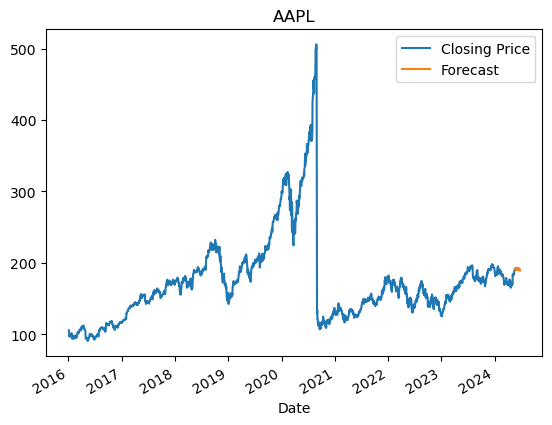

In [7]:
next_date = df_past['Date'].iloc[-1] + pd.Timedelta(days=1)
df_future['Date'] = pd.date_range(start=next_date, periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Closing Price'] = np.nan

# Concatenate df_past and df_future
results = pd.concat([df_past, df_future])

# Set the index to 'Date'
results.set_index('Date', inplace=True)

# plot the results
results.plot(title=f'{symbol}')

In [8]:
print(results.tail())

            Closing Price    Forecast
Date                                 
2024-06-17            NaN  190.474762
2024-06-18            NaN  191.490814
2024-06-19            NaN  191.131714
2024-06-20            NaN  191.186172
2024-06-21            NaN  188.794785


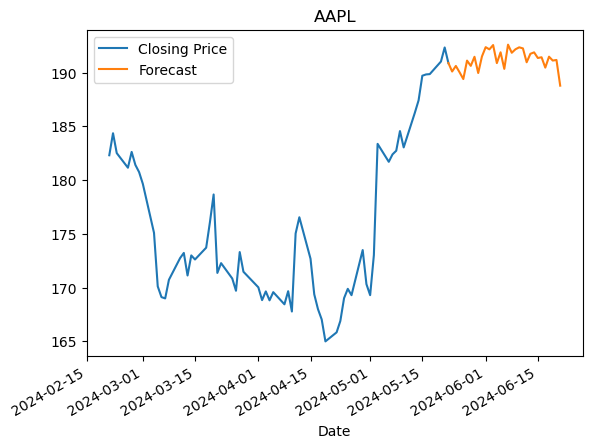

In [9]:
import matplotlib.pyplot as plt

# Get the current date
current_date = results.index[-1]

# Calculate the date 4 months ago
four_months_ago = current_date - pd.DateOffset(months=4)

# Slice the DataFrame to include only the data from the last 4 months
results_last_4_months = results[four_months_ago:current_date]

# Plot the results for the last 4 months
results_last_4_months.plot(title=f'{symbol}')

# Show the plot
plt.show()